In [1]:
# %pip install albumentations --user

In [2]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:

import torch
 
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.4
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060


In [4]:
import os, cv2
import numpy as np
# %pip install --force-reinstall pandas
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
from PIL import Image

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [5]:
# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
# !pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

c:\Users\cliente\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
DATA_DIR = 'data/patches'

# ler as pastas masks e images e criar um csv com os caminhos
def create_df(data_path):
    data = []
    index = 0
    for image in os.listdir(data_path):
      # se a imagem tiver _m antes do .png, é uma máscara
      if '_m' in image:
        mask_path = os.path.join(data_path, image)
        sat_image = image.replace('_m', '')
        sat_image = sat_image.replace('.png', '.jpg')
        sat_image_path = os.path.join(data_path, sat_image)
        data.append([index, sat_image_path, mask_path])
        index += 1
    return pd.DataFrame(data, columns=['image_id', 'dat_image_path', 'mask_path'])
  
df = create_df(DATA_DIR)
df.head()

,image_id,dat_image_path,mask_path
0,0,data/patches\M-33-20-D-c-4-2_0.jpg,data/patches\M-33-20-D-c-4-2_0_m.png
1,1,data/patches\M-33-20-D-c-4-2_100.jpg,data/patches\M-33-20-D-c-4-2_100_m.png
2,2,data/patches\M-33-20-D-c-4-2_101.jpg,data/patches\M-33-20-D-c-4-2_101_m.png
3,3,data/patches\M-33-20-D-c-4-2_102.jpg,data/patches\M-33-20-D-c-4-2_102_m.png
4,4,data/patches\M-33-20-D-c-4-2_103.jpg,data/patches\M-33-20-D-c-4-2_103_m.png


In [7]:
# salvar o csv
df.to_csv('metadata_patches.csv', index=False)

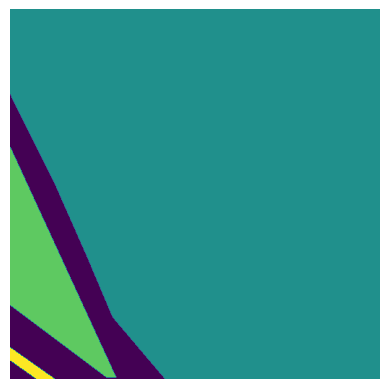

In [8]:
mask = cv2.imread(df['mask_path'][110], cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)
plt.axis('off')
plt.show()

In [9]:
# Labels:
# 0: Unlabeled background ​
# 1: Buildings​
# 2: Woodlands​
# 3: Water​

# create csv with the labels
def create_label_csv():
    data = [[0, 'Unlabeled background'], [1, 'Buildings'], [2, 'Woodlands'], [3, 'Water']]
    return pd.DataFrame(data, columns=['label', 'name'])
  
label_df = create_label_csv()
label_df.to_csv('class_dict.csv', index=False)

In [10]:
# eu tenho um txt com todas as imagens que são para treino, crie um dataframe com essas imagens
def create_train_df(data_path, txt_path):
    train_images = []
    with open(txt_path, 'r') as file:
        for line in file:
            image = line.strip()
            mask_path = os.path.join(data_path, f'{image}_m.png')
            image_path = os.path.join(data_path, f"{image}.jpg")
            train_images.append([image_path, mask_path])
    return pd.DataFrame(train_images, columns=['image', 'mask_path'])
  
train_df = create_train_df(DATA_DIR, 'data/train.txt')
train_df.head()

,image,mask_path
0,data/patches\M-33-20-D-c-4-2_0.jpg,data/patches\M-33-20-D-c-4-2_0_m.png
1,data/patches\M-33-20-D-c-4-2_1.jpg,data/patches\M-33-20-D-c-4-2_1_m.png
2,data/patches\M-33-20-D-c-4-2_10.jpg,data/patches\M-33-20-D-c-4-2_10_m.png
3,data/patches\M-33-20-D-c-4-2_100.jpg,data/patches\M-33-20-D-c-4-2_100_m.png
4,data/patches\M-33-20-D-c-4-2_102.jpg,data/patches\M-33-20-D-c-4-2_102_m.png


In [11]:
def create_test_df(data_path, txt_path):
    test_images = []
    with open(txt_path, 'r') as file:
        for line in file:
            image = line.strip()
            mask_path = os.path.join(data_path, f'{image}_m.png')
            image_path = os.path.join(data_path, f"{image}.jpg")
            test_images.append([image_path, mask_path])
    return pd.DataFrame(test_images, columns=['image', 'mask_path'])
  
test_df = create_test_df(DATA_DIR, 'data/test.txt')
test_df.head()

,image,mask_path
0,data/patches\M-33-20-D-c-4-2_105.jpg,data/patches\M-33-20-D-c-4-2_105_m.png
1,data/patches\M-33-20-D-c-4-2_110.jpg,data/patches\M-33-20-D-c-4-2_110_m.png
2,data/patches\M-33-20-D-c-4-2_117.jpg,data/patches\M-33-20-D-c-4-2_117_m.png
3,data/patches\M-33-20-D-c-4-2_120.jpg,data/patches\M-33-20-D-c-4-2_120_m.png
4,data/patches\M-33-20-D-c-4-2_124.jpg,data/patches\M-33-20-D-c-4-2_124_m.png


In [12]:
def create_valid_df(data_path, txt_path):
    valid_images = []
    with open(txt_path, 'r') as file:
        for line in file:
            image = line.strip()
            mask_path = os.path.join(data_path, f'{image}_m.png')
            image_path = os.path.join(data_path, f"{image}.jpg")
            valid_images.append([image_path, mask_path])
    return pd.DataFrame(valid_images, columns=['image', 'mask_path'])
  
valid_df = create_valid_df(DATA_DIR, 'data/val.txt')
valid_df.head()

,image,mask_path
0,data/patches\M-33-20-D-c-4-2_101.jpg,data/patches\M-33-20-D-c-4-2_101_m.png
1,data/patches\M-33-20-D-c-4-2_103.jpg,data/patches\M-33-20-D-c-4-2_103_m.png
2,data/patches\M-33-20-D-c-4-2_113.jpg,data/patches\M-33-20-D-c-4-2_113_m.png
3,data/patches\M-33-20-D-c-4-2_116.jpg,data/patches\M-33-20-D-c-4-2_116_m.png
4,data/patches\M-33-20-D-c-4-2_126.jpg,data/patches\M-33-20-D-c-4-2_126_m.png


In [13]:
print(f"Train size: {train_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")
print(f"Validation size: {valid_df.shape[0]}")

Train size: 7470
Test size: 1602
Validation size: 1602


In [14]:
from torch.utils.data import Dataset
class LandcoverDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
      image_path = self.df['image'].iloc[idx]
      mask_path = self.df['mask_path'].iloc[idx]
      
      image = cv2.imread(image_path)
      mask = cv2.imread(mask_path)

      if self.transform:
          label = mask[:, :, 1]
          transformed = self.transform(image=image, mask=label)
          img = np.transpose(transformed["image"], (2, 0, 1))
          label = transformed["mask"]
      else:
          img = np.transpose(image, (2, 0, 1))
          label = mask[:, :, 1]

      # Adicionar dimensão extra para a máscara
      label = np.expand_dims(label, axis=0)
      
      del mask
      return torch.tensor(img, dtype=torch.float32) / 255, torch.tensor(label, dtype=torch.int64)
  

In [15]:
def get_augmentation ():
    train_transform = [
        album.OneOf([
            album.HueSaturationValue(40,40,30,p=1),
            album.RandomBrightnessContrast(p=1,brightness_limit = 0.2,
                                        contrast_limit = 0.5)], p = 0.5),
        album.OneOf([
            album.RandomRotate90(p=1),
            album.HorizontalFlip(p=1),
            album.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)
            ], p = 0.5)
    ]
    return album.Compose(train_transform)
  
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['buildings', 'woodlands', 'water', 'background', 'road']

In [16]:
train_set = LandcoverDataset(train_df, transform = get_augmentation())
test_set = LandcoverDataset(test_df)
valid_set = LandcoverDataset(valid_df)

In [17]:
batch_size = 16
train_dloader = DataLoader(train_set, batch_size = batch_size,
                           shuffle = True, num_workers = 0)
test_dloader = DataLoader(test_set, batch_size = batch_size, num_workers = 0)
val_dloader = DataLoader(valid_set, batch_size=batch_size, num_workers = 0)

In [18]:
# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation='softmax'
)

In [19]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=5e-5),
])

loss = smp.utils.losses.DiceLoss()


metrics = [
    smp.utils.metrics.IoU(),
    smp.utils.metrics.Fscore(),
    smp.utils.metrics.Accuracy()
]

# create epoch runners
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)


In [20]:
# Source: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [21]:
import torchmetrics
from torch.optim import Adam
import time
import seaborn as sns

def training_loop(model, train_loader, val_loader, epochs,
                  lr, loss_fn, regularization=None,
                  reg_lambda=None, mod_epochs=5, early_stopping = False,
                  patience = None, verbose = None, model_title = None, save = None,
                 stopping_criterion = "loss"):
    if stopping_criterion not in ["loss","IoU"]:
        raise ValueError(f"Critério de parada deve ser 'loss' ou 'IoU', nao {stopping_criterion}.")
    print("Treinamento de " + model_title + " iniciou!")

    tic = time.time()
    
    optim = Adam(model.parameters(), lr=lr)
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        
    if stopping_criterion == "IoU":
        jaccard = torchmetrics.JaccardIndex(num_classes = 5).to(device)

        iou_loss_list = []

    train_loss_list = []
    val_loss_list = []
    num_train_batches = len(train_loader)
    num_val_batches = len(val_loader)
    counter_epochs = 0

    if early_stopping:
        ear_stopping = EarlyStopping(patience= patience, verbose=verbose)

    for epoch in range(epochs):
        counter_epochs+=1
        model.train()
        train_loss, val_loss = 0.0, 0.0
        
        if stopping_criterion == "IoU": iou_loss = 0.0 
        for train_batch in train_loader:
            X, y = train_batch[0].to(device), train_batch[1].to(device)
            preds = model(X)
            loss = loss_fn(preds, y)
            train_loss += loss.item()
            if stopping_criterion == "IoU":
                iou_loss += 1- float(jaccard(preds, y).cpu())

            # Regulirization
            if regularization == 'L2':
                l_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss = loss + reg_lambda * l_norm
            elif regularization == 'L1':
                l_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + reg_lambda * l_norm

            # Backpropagation
            optim.zero_grad()
            loss.backward()
            optim.step()
        model.eval()
        with torch.no_grad():
            for val_batch in val_loader:
                X, y = val_batch[0].to(device), val_batch[1].to(device)
                preds = model(X)
                if stopping_criterion == "loss":
                    val_loss += loss_fn(preds, y).item()
                else:
                    # Calculate the 1-IoU as validation loss
                    val_loss += 1-float(jaccard(preds,y).cpu())
        train_loss /= num_train_batches
        val_loss /= num_val_batches
        if stopping_criterion == "IoU":
            iou_loss /= num_train_batches
            iou_loss_list.append(iou_loss)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        if (epoch + 1) % mod_epochs == 0:
            if stopping_criterion == "loss":
                print(
                    f"ÉPOCA: {epoch + 1}/{epochs}{5 * ' '} Loss de treino: {train_loss:.4f}{5 * ' '} Loss de validacao: {val_loss:.4f}")
            else:
                print(
                    f"ÉPOCA: {epoch + 1}/{epochs}{5 * ' '} IoU Loss de treino: {iou_loss:.4f}{5 * ' '} IoU Loss de validacao: {val_loss:.4f}{5*' '} Loss de treino: {train_loss:.4f}")
                
                

        if early_stopping:
            ear_stopping(val_loss, model)
            if ear_stopping.early_stop:
                print("Early stopping")
                break
    sns.set_style("dark")
    fig, ax = plt.subplots(figsize=(8, 8))
    if stopping_criterion == "loss":
        ax.plot(range(1, counter_epochs + 1), train_loss_list, label='Train Loss',
               color = "#808080", linewidth = 2.5)
    else:
        ax.plot(range(1, counter_epochs + 1), iou_loss_list, label='Train IoU Loss',
               color = "#808080", linewidth = 2.5)
    ax.plot(range(1, counter_epochs + 1), val_loss_list, label='Val Loss',
            color = "#36454F", linewidth = 2.5)
    ax.set_title(model_title, fontsize = 15)
    ax.set_ylabel("Loss", fontsize = 13)
    ax.set_xlabel("Epochs", fontsize = 13)
    plt.legend()
    if save is not None:
        plt.savefig(model_title + ".png")
    plt.show()

    if early_stopping:
        model.load_state_dict(torch.load("best_model.pt"))
    total_time = time.time() - tic
    mins, secs = divmod(total_time, 60)
    if mins < 60:
        print(f"\n Training completed in {mins} m {secs:.2f} s.")
    else:
        hours, mins = divmod(mins, 60)
        print(f"\n Training completed in {hours} h {mins} m {secs:.2f} s.")
        

In [22]:
# train model for 50 epochs
EPOCHS = 50

lr = 5e-5

training_loop(model, train_dloader, val_dloader, EPOCHS, lr, loss, mod_epochs =1,
             regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
             patience = 5, verbose = True, model_title = "DeepLabV3+ with Resnet50 encoder", save = True,
             stopping_criterion = "loss")
# training_loop(model, train_dloader, val_dloader, EPOCHS, loss, model_title = "DeepLabV3Plus", model_path = "DeepLabV3Plus.pth", stopping_criterion = "loss")

Training of DeepLabV3+ with Resnet50 encoder starts!
Using loss as stopping criterion.



c:\Users\cliente\miniconda3\envs\tf\lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 1/50     Training Loss: 0.0484     Validation Loss: 0.1466
Validation loss decreased (inf --> 0.146648).  Saving model ...
